<a href="https://www.kaggle.com/code/matteoanzano111/decoding-bee-decline-a-random-forest-analysis?scriptVersionId=153707385" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Decoding Bee Decline: a Random Forest Analysis

In this notebook, we will explore the relationship between the percentage of lost colonies, time, and agents affecting them using a *Random Forest* model and *SHAP Values*.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score  
from sklearn.model_selection import GridSearchCV
import shap


In [2]:
df=pd.read_csv("/kaggle/input/save-the-honey-bees/save_the_bees.csv")
df=df.loc[df.state!='United States']

In this dataset, information is recorded quarterly for 30 states from 2015 to 2022. The data includes details about bee colonies, such as total, lost, added, and renovated values, as well as information about the percentage of dangerous agents, such as varroa mites, diseases, and unknown agents.

# Explorative analysis

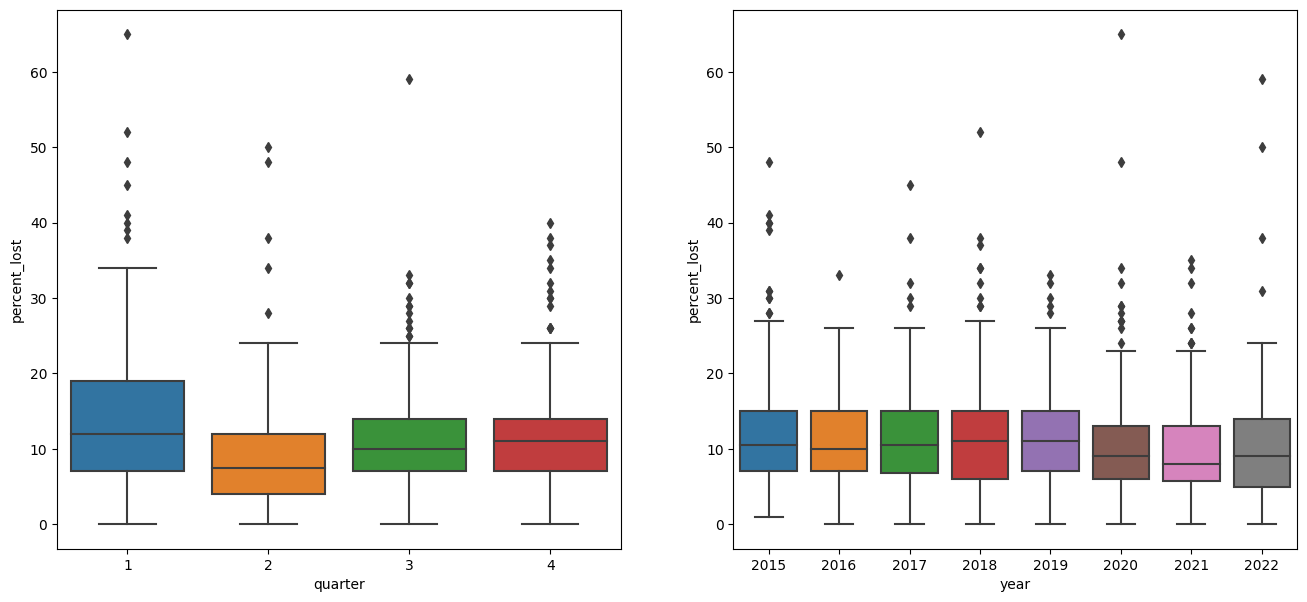

In [3]:
figure, axes = plt.subplots(1, 2, figsize=(16,7)) 
sns.boxplot(ax=axes[0],data=df,y='percent_lost',x='quarter')
sns.boxplot(ax=axes[1],data=df,y='percent_lost',x='year')
plt.show()

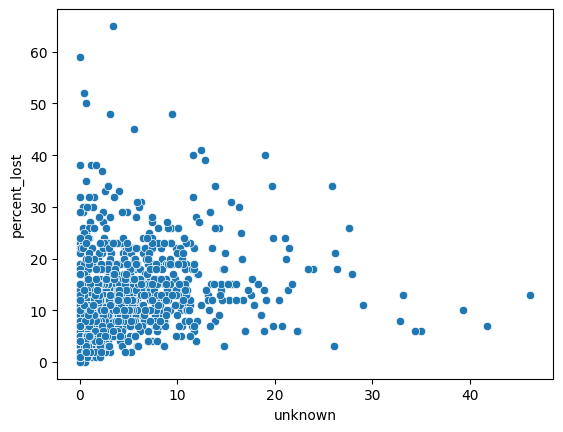

In [4]:
sns.scatterplot(data=df,y='percent_lost',x='unknown')
plt.show()

From exploratory graphs, it is evident that there is an increase in the percentage of colonies lost during the first *quarter*. Moreover, in the last few *years*, there has been a slight decrease in the percentage of colonies lost. Additionally, it appears that the presence of *unknown* agents is not strongly correlated with the percentage of colonies lost

# Random forest

In [5]:
df=df.drop(['num_colonies','lost_colonies', 'renovated_colonies', 'state'], axis=1)
target_variable='percent_lost'

In [6]:
data_X=df.drop(target_variable, axis=1)
data_y=df[target_variable]
train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, random_state = 0)

In [7]:
param_grid_rf = {
    'n_estimators': [200,400,600],
    #'max_depth': [10,15,20],
    #'min_samples_split': [5,10]
    'max_features':[2,4,6,8]
}

# Create the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Instantiate GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, 
                           cv=5, n_jobs=-1, verbose=0)

# Perform Grid Search to find the best parameters
grid_search_rf.fit(train_X, train_y)

# Best parameters and best estimator
best_params = grid_search_rf.best_params_
rf_model = grid_search_rf.best_estimator_
best_params

{'max_features': 2, 'n_estimators': 600}

In [8]:
rf_model.fit(train_X, train_y)
rf_pred=rf_model.predict(test_X)
rf_error = np.sqrt(mean_squared_error(test_y, rf_pred))
rf_error

5.622735434014643

The Random Forest has an error about 5.6. That is a good accuracy considering percentege lost range. 
However we know that Random Forest has a downside: using them is not possible to interpeter the indipendent variables effect. 

Feature Importance is a way to understand the most important variables, while Shapley value is a method to further explore the effect of each indipendent variable.

# Feature importance

In [9]:
def plot_feature_importance(importance,names,model_type, n):

#Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

#Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df=fi_df.iloc[0:n,:]

#Define size of bar plot
    plt.figure(figsize=(10,8))
#Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

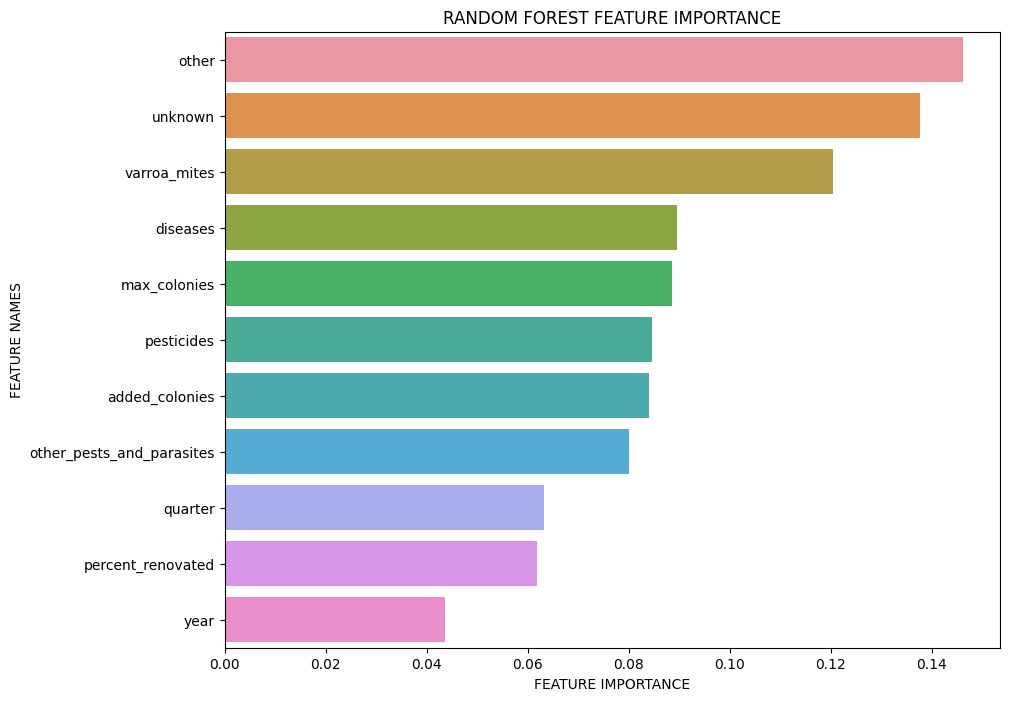

In [10]:
plot_feature_importance(rf_model.feature_importances_,train_X.columns,'RANDOM FOREST',15)


The most important variables are the agents, with a particular emphasis on *other*, *unknown*, and *varroa_mites*.

# SHAP Values

*SHAP Values* are obtained from machine learning models. Considering an observation *i*, a positive *SHAP Value* for the variable *j* indicates that, for that specific subject, the variable has a positive impact on the response variable. It is possible to use *SHAP Values* in various ways to explore the effects of independent variables on the response variable.

In [11]:
explainer=shap.TreeExplainer(rf_model)
explanation = explainer(test_X)

In [12]:
shap.initjs()
shap.force_plot( explanation[42])

Through this plot, we have extracted a random observation from the test set. It is observed that the *percentage lost* for that observation is predicted to be 9.42, slightly lower than the mean, which is 11.25. The red variables are the ones that increase the response value, while the blue variables decrease it. 

So, the reason for having such a low value of percentage lost is the *unknown* variable, which is only equal to 0.9. Instead, the *other* variable with a value of 5.2 increases the value of the response variable.

So, it is possible to use these plots to understand, for each observation, the reasons for having a high or low value of percentage lost. For example, in the next graph, the SHAP Values of the observation with the maximum predicted *percentage lost* value are observed. The value is equal to 27.91, and the main reasons are *other*, *unknown*, and *quarter*=1, which significantly increase the *percentage lost*.

In [13]:
max=np.argmax(rf_pred)
shap.initjs()
shap.force_plot( explanation[max])

Through the next graph, it is possible to study the importance of each variable. The graph orders the variables in importance order. A variable is deemed important when it is useful in predicting the response variable. Therefore, it is crucial if the *SHAP Values* clearly depend on the values of the variable itself. For example, it's evident that *SHAP Values* are high when *unknown* and *other* are high, and *quarter* is low. The subsequent variables show a less clear difference in *SHAP Values*, and therefore, they are considered less important.

It's interesting to note that the most important variables identified by *SHAP Values* are similar to the ones obtained through *Feature Importance*

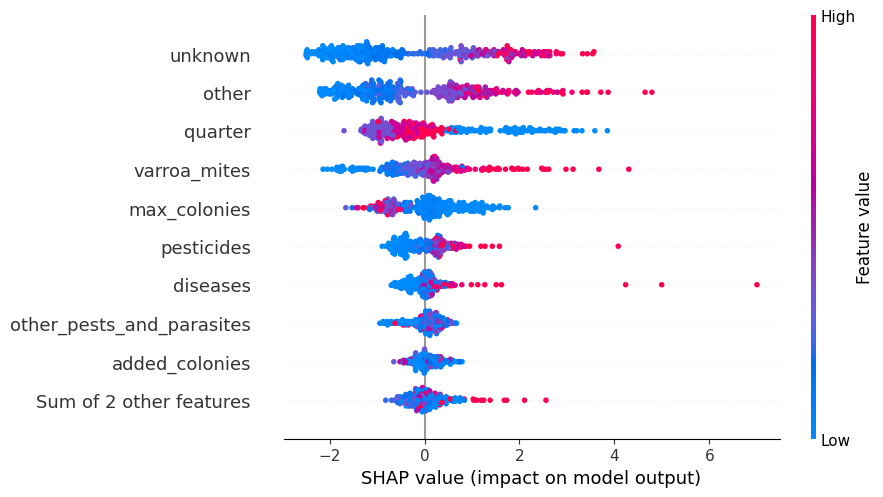

In [14]:
shap.plots.beeswarm(explanation,max_display=10)


In [15]:
shap_values = explainer.shap_values(test_X)


It's also possible to study the effect of each indipendent variable through scatterplots. The next plot shows the *Shapley values* for each *year* and for different *quarters*, displayed through colors. That plot shows the effect of *year* and its interaction effect with *quarter*.
It's clear that there is a decreasing pattern, indicating that throughout the *years*, there is a decrease in *percentage lost*. Moreover, we observe that the yearly decrease is especially high in the first *quarter*, as the blue points show a higher negative slope. That probably means that over the years, solutions have been found to mitigate winter bee loss, or it could be attributed to climate change, making winters less dangerous for bees.

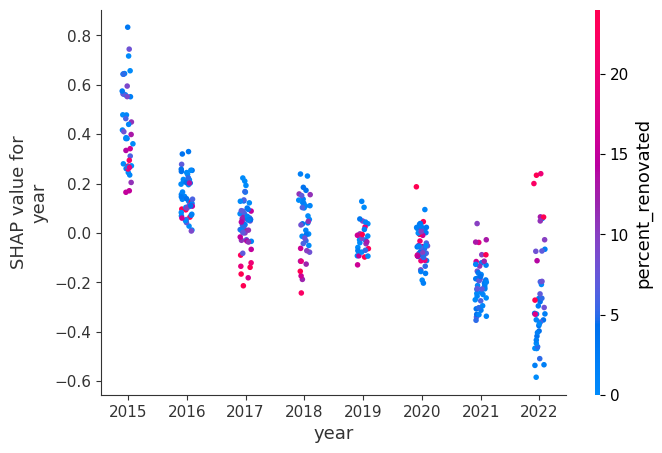

In [16]:
shap.dependence_plot('year', shap_values, test_X, x_jitter=0.2)


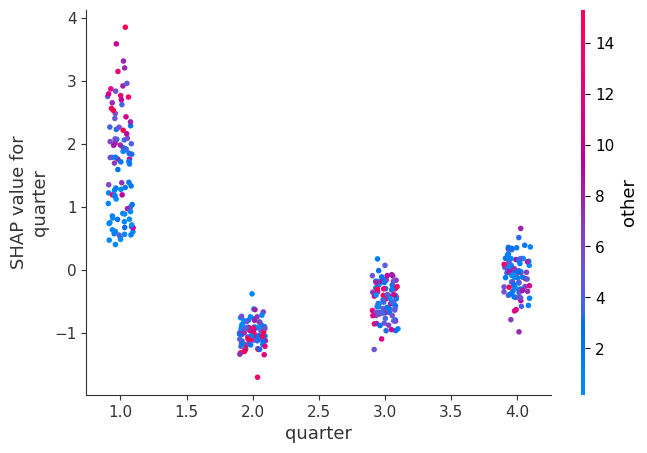

In [17]:
shap.dependence_plot('quarter', shap_values, test_X, x_jitter=0.2, interaction_index="other")


In the second plot, it is observed that in the first *quarter*, the *SHAP Values* are positive, while in the other *quarters*, they are negative. This indicates that it's in the first *quarter* that the *percentage lost* increases. 

Moreover, we observe that when focusing only on the blue dots, that correspond to low values of *other* agents, the difference is lower, while it's higher when focusing on magenta points, that correspond to high values of *other* agents. This implies that when the percentage of 'other' agents affecting the colonies is high, the mortality in the first quarter increases significantly more.

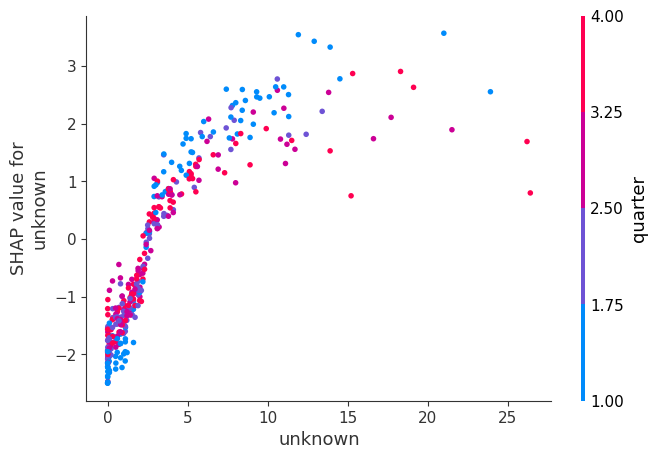

In [18]:
shap.dependence_plot('unknown', shap_values, test_X, x_jitter=0.2, interaction_index="auto")


Finally, in this plot, we aim to study the effect of *unknown* agents. It's clear that there is an increasing trend, indicating that a higher presence of *unknown* agents increases the *percentage lost*. When focusing on low values of *varroa mites* (blue dots), the slope is higher, while focusing on high values of *varroa mites* (magenta dots), the slope decreases and reaches a plateau. This suggests that *unknown* agents are especially dangerous when there is a low presence of *varroa mites*, while their effect is lower if there is a high presence of *varroa mites*.

It's possible to conclude that through *Random Forest*, accurate predictions are obtained, and that *SHAP Values* reveal relationships that explorative analysis does not showcase.